In [1]:
 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


%matplotlib inline	


### Data Preparation

First, we must load the data and then transform it into a usable condition to pass into the One-Class Support Vector Machine (OC-SVM) algorithm.

We define a list of columns that correspond with the data. Unlike some other data files, the data does not contain columns so we must define them ourselves to tell pandas what the column labels should be. Otherwise, they'll be numbered by numerical index, making it harder to interpret the data.

In [2]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("data/kddcup.data.corrected", sep=",", names=columns, index_col=None)


This is a very large dataset. Let's only concern ourselves with http attacks

In [3]:
# Filter to only 'http' attacks
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)


There are many types of anomalous attacks. To make things simple, we will only detect whether a data point is normal or if it is an anomaly

In [4]:
# Label of 'normal.' becomes 0, and anything else becomes 1 and is treated as an anomaly.
df['label'] = df['label'].apply(lambda x: 0 if x=='normal.' else 1)
df['label'].value_counts()

label
0    619046
1      4045
Name: count, dtype: int64

The next step we should perform is to encode the categorical columns. However, there are many columns to search over, so let's automate this. The following cell will create a dictionary of column names to their corresponding data type. From that data type dictionary, we can iterate and find only the columns that are strings, which carry a datatype of "object" in pandas.

Additionally, we will be applying **standard scaling** to all the numeric columns. When all the variables are on a similar scale, the one-class support vector machine can arrive at a solution much more easily. This is a crucial step for support vector machine models.

In [5]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))
encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder 
    else:
        if col == 'label':
            continue 
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        encoder_map[col] = scaler 


In [6]:
# Check the variables with highest correlation with 'label'
df2 = df.copy()
label_corr = df2.corr()['label']

Now that we have filtered out only the columns with a stronger correlation with label, let's split our data into train-test-val splits.

In [7]:
# Filter out anything that has null entry or is not weakly correlated
train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > 0.2)]
train_cols = list(train_cols[:-1].index)
labels = df2['label']

# Conduct a train-test split    
x_train, x_test, y_train, y_test = train_test_split(df2[train_cols].values, labels.values, test_size = 0.15, random_state = 42)


In [8]:
# Additional split of training dataset to create validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [9]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(423701, 13)
y_train:(423701,)

x_val:(105926, 13)
y_val:(105926,)

x_test:(93464, 13)
y_test:(93464,)


Since the OC-SVM only trains on data belonging to one class (since it is used for novelty / outlier detection), we need to split the dataset into one part comprised only of normal instances (to be used for training), and another part that combines a mixture of normal data and just the anomalies.

In [10]:
# Split a set into 80% only normal data, and 20% normal data + any anomalies in set
def split_by_class(x, y):
    # Separate into normal, anomaly
    x_normal = x[y == 0]
    x_anom = x[y==1]
    
    y_normal = y[y==0]
    y_anom = y[y==1]
    
    # Split normal into 80-20 split, one for pure training and other for eval
    x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_normal, y_normal, test_size=0.2, random_state=42)
    
    # Combine the eval set with the anomalies to test outlier detection
    x_train_test = np.concatenate((x_train_test, x_anom))
    y_train_test = np.concatenate((y_train_test, y_anom))
    
    # Shuffle the eval set
    random_indices = np.random.choice(list(range(len(x_train_test))), size=len(x_train_test), replace=False)
    x_train_test = x_train_test[random_indices]
    y_train_test = y_train_test[random_indices]
    
    return x_train_train, x_train_test, y_train_train, y_train_test
                        
    

We will split up our training dataset this way.

In [11]:
### Train on normal data only. The _test splits have normal and anomaly data both
x_train_train, x_train_test, y_train_train, y_train_test = split_by_class(x_train, y_train)

In [12]:
print(f"x_train_train: {x_train_train.shape}")
print(f"y_train_train: {y_train_train.shape}")   
print(f"x_train_test: {x_train_test.shape}") 
print(f"y_train_test: {y_train_test.shape}") 

x_train_train: (336728, 13)
y_train_train: (336728,)
x_train_test: (86973, 13)
y_train_test: (86973,)


One issue with the OC-SVM is that the training time scales very poorly with data. And so, for the sake of prototyping, we will be using far fewer samples than usual to find the optimal set of hyperparameters and then scale it back up. 

In [12]:
# nu is a cap on the upper bound of training errors and lower bound of the fraction of support vectors. We will first try to enter the expected amount of anomalies
svm = OneClassSVM(nu=0.0065, gamma=0.05)
svm.fit(x_train_train[:50000])

OneClassSVM(gamma=0.05, nu=0.0065)

Predictions returned are either:
- 1 -> normal data (inlier)
- -1 -> anomaly data (outlier)

So, to convert the predictions to be in terms of 0 (normal) or 1 (anomaly), we only need to apply a boolean condition of:

preds < 0

Since -1, the anomaly, is less than 0, it evaluates to True, which is converted to 1.
Likewise, 1, the normal point, is greater than 0, which evaluates to False, which converts to 0.


In [13]:
preds = svm.predict(x_train_test)
# -1 is < 0, so it flags as 1. 1 is > 0, so flags as 0.
preds = (preds < 0).astype(int) 
preds

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
pre = precision_score(y_train_test, preds )
rec = recall_score(y_train_test, preds)
f1 = f1_score(y_train_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")


Precision: 0.8310991957104558
Recall: 1.0
F1-Measure: 0.9077598828696926


This looks like a really good score just evaluating on a \_test split derived from the training data. 

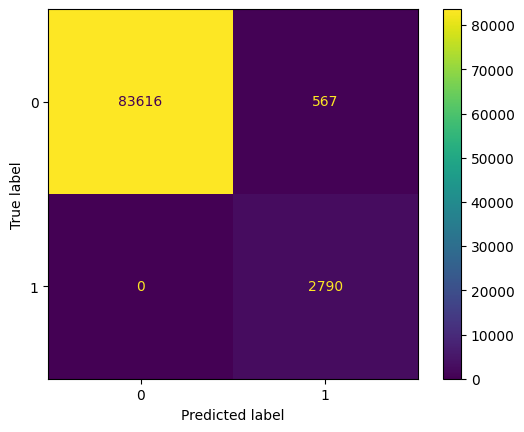

In [15]:
ConfusionMatrixDisplay(confusion_matrix(y_train_test, preds)).plot()

The confusion matrix looks good overall - there were no anomalies that were false negatives, but there were more than a few false positives. Now let's see how this works on our original test split.

In [16]:

preds = svm.predict(x_test)
preds = (preds < 0).astype(int) # -1 is < 0, so it flags as 1. 1 is > 0, so flags as 0.
preds

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
pre = precision_score(y_test, preds )
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")


Precision: 0.4809805579036348
Recall: 1.0
F1-Measure: 0.6495433789954338


It seems like our model massively overfit to the training data, since the F1-measure is so low compared to earlier. It makes sense that the performance looked good on the x_train_test split because this was derived from the training data, and thus has a similar distribution. The test split was completely different and was never involved in the training process.

We now need to look at hyperparameter tuning to see if we can get this model to generalize better.

Of interest are the following hyperparameter settings:
- **gamma**: A parameter used in the RBF kernel function. It determines the radius of influence that points have on each other, with smaller gamma translating to larger radii. We want the radius of influence to be as large as possible to include all the outliers, but not too large, or else the model ends up learning nothing important. If gamma is too large, then the SVM will try and fit the training data more closely, which might lead to overfitting. This makes gamma an important parameter to tune.

- **nu**: This is an upper bound on the fraction of training errors allowed and a lower bound on the fraction of support vectors. It is a more sensitive hyperparameter than gamma and it can influence the output behavior of the model quite a bit, so it is very important to tune this value according to your dataset. You may also need to retune this even if your training data size changes. A very small nu places a stricter requirement on how many training errors are allowed, while a larger nu value allows for more training errors to slip through when training the model.


In [18]:
# Given an svm instance, x, and y data, train and evaluate and return results
def experiment(svm, x_train, y_train, x_test, y_test):
    
    # Fit on the training data, predict on the test
    svm.fit(x_train)
    
    preds = svm.predict(x_test)
    
    # Predictions are either -1 or 1
    preds = (preds < 0).astype(int)
    
    pre = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    
    return {'precision': pre, 'recall': rec, 'f1': f1}
    

In [19]:
# Perform experimental search for best gamma parameter
validation_results = {}
gamma = [0.005, 0.05, 0.5]
for g in gamma:
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    svm = OneClassSVM(nu=0.0065, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res
    
                       

In [20]:
# Printing out the results of the validation. 
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.005, 0.6390312063344201),
 (0.05, 0.6253418413855971),
 (0.5, 0.5301391035548686)]

In [21]:
# Perform experimental search for gamma with a narrower range. Looks like smaller gamma is better
validation_results = {}
# Search 1e-5, 5e-5, 1e-4, 1.5e-4, 1e-3, 1.5e-3 and 2e-3
gamma = [1, 5, 10, 15, 20, 100, 150, 200]
for g in gamma:
    g = g / 100000.0
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    svm = OneClassSVM(nu=0.0065, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res
    
                       

In [22]:
# Printing out the results of the validation.
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(1e-05, 0.6605681271064034),
 (5e-05, 0.6502369668246446),
 (0.0001, 0.6411214953271028),
 (0.00015, 0.6414212248714353),
 (0.0002, 0.6414212248714353),
 (0.001, 0.6363636363636364),
 (0.0015, 0.6381395348837209),
 (0.002, 0.6351851851851852)]

Let's try the gamma value of 1e-5 and now tune **nu**.

In [23]:
# Perform experimental search for nu
validation_results = {}
nu = range(1, 10)
for n in nu:
    n = n / 1000.0
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    svm = OneClassSVM(nu=n, gamma=0.00001)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res
    
                       

In [24]:
# Printing out the results of the validation. 
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.001, 0.921832884097035),
 (0.002, 0.8612680477087257),
 (0.003, 0.8094395280235989),
 (0.004, 0.7639198218262806),
 (0.005, 0.6656962639495391),
 (0.006, 0.7183246073298429),
 (0.007, 0.6316758747697975),
 (0.008, 0.6028119507908611),
 (0.009, 0.5688225538971807)]

In [25]:
# Perform experimental search for nu with a finer range
validation_results = {}
nu = range(1, 11)#[0.005, 0.0065, 0.01, 0.015]
for n in nu:
    n = n / 10000.0
    
    # We are fixing the n_estimators to 50 to be quicker. n_jobs = -1 lets us train on all cores
    svm = OneClassSVM(nu=n, gamma=0.00001)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res
                           

In [26]:
# Printing out the results of the validation. The optimal setting is between 512 and 2048
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.0001, 0.9032761310452418),
 (0.0002, 0.9607982893799002),
 (0.0003, 0.9540636042402827),
 (0.0004, 0.9489153254023793),
 (0.0005, 0.9517144856543037),
 (0.0006, 0.941908713692946),
 (0.0007, 0.9406077348066298),
 (0.0008, 0.9387474191328287),
 (0.0009, 0.9368998628257887),
 (0.001, 0.921832884097035)]

Now that we have found the optimal nu setting of 0.0002, let's try and train the model.

It turns out that gamma = 1e-5 was not performing that well once the data size increased. We upped it to 0.005, which produced favorable results and allowed the model to generalize better.

In [27]:
# We increased gamma back to 0.005 as it helped with the fit once we increased the number of samples.
svm = OneClassSVM(nu=0.0002, gamma=0.005)
svm.fit(x_train_train[:])

OneClassSVM(gamma=0.005, nu=0.0002)

In [28]:
preds = svm.predict(x_test)
preds = (preds < 0).astype(int)

In [29]:
pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")


Precision: 0.9709897610921502
Recall: 1.0
F1-Measure: 0.9852813852813853


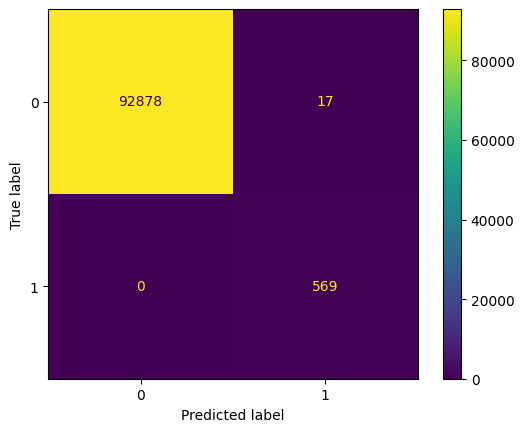

In [30]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()

Analyzing the confusion matrix, this model did very well. There are no false negatives, and only 17 false positives.

One-Class SVM is much more sensitive and responsive to dataset processing and hyperparameter tuning, but it is capable of producing strong results.